In [1]:
import os 

# Limit GPU consumption
DEVICE = '2'
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE

os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"  # add this
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

import jax
import jax.numpy as jnp
import numpy as np

# import haiku as hk
# import optax
from einops import repeat, rearrange

import matplotlib.pyplot as plt

import importlib
import sys

import wandb
import cellpylib as cpl

import model
import dataloader
import trainer
# from model import network_fn, logit_to_preds
# from dataloader import make_game_of_life
importlib.reload(sys.modules['model'])
importlib.reload(sys.modules['dataloader'])
importlib.reload(sys.modules['trainer'])
from model import network_fn, logit_to_preds
from dataloader import make_game_of_life, dataloader
from trainer import Trainer, Batch, TrainState

wandb.login()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /home/sradev/.netrc


True

In [2]:
## First we create a config file

# Some hyperparameters
num_classes = 2  # number of classes per cell (i.e. bits)
wspan, hspan = 60, 60  # height and width of grid
layer_dims = [10, 10, 10, 10] # let's add a third layer for depth
train_size = 30

# Create a dictionary of hyperparameters
config = {
    "train_size": train_size,          # number of samples 
    "wspan": wspan,             # width of grid 
    "hspan": hspan,             # height of grid
    "num_classes": num_classes, # number of states for each cell
    "layer_dims": layer_dims,
    "learning_rate": 1e-2
}

generate_gol_data = dataloader(config['num_classes'],
    config['wspan'],
    config['hspan']
)

# X_train, Y_train = generate_gol_data(
#     config['train_size']
# )

# print(X_train.shape, Y_train.shape, X_train.dtype)

In [3]:
## Now we start playing with getting different datasets (besides just the game of life)

def generate_totalistic_data(config, random_rule=None, random_init=True, stride=1):
    """
    Uses the cellpylib library to get X and Y datasets from 2D totalistic rules. Also allows
    the game of life. 

    :param config: dict, the configuration dictionary used in this code infrastructure
    :param random_rule: int, the code corresponding to a specific 2D rule. Default None.
    :param random_init: bool, whether to initialize the grid randomly or from a single seed. Default True.
    :param stride: int, a number telling how many time steps apart is each
        corresponding (x, y) pair in the dataset. Default 1. 

    :return: tuple of X train set, Y train set, and the updated configuration dictionary
    """

    hspan, wspan = config['hspan'], config['wspan']
    k = config['num_classes']
    timesteps = stride * config['train_size']
    # train_size = config['train_size']

    if random_rule is None:
        # For k=2, the maximum rule number is 1023 (I think)
        random_rule = np.random.randint(1024) # get some random number
    
    # First create the initial grid
    if random_init:
        initial_ca_state = cpl.init_random2d(rows=hspan, cols=wspan, k=k)
    else:  # Else initialize with single seed in the center
        initial_ca_state = cpl.init_simple2d(rows=hspan, cols=wspan)

    # If random rule is the Game of Life
    if random_rule == 'gol':
        cellular_automaton = cpl.evolve2d(initial_ca_state, timesteps=timesteps, 
                     apply_rule=cpl.game_of_life_rule, memoize='recursive')
    else:    
        cellular_automaton = cpl.evolve2d(initial_ca_state, timesteps=timesteps, memoize=True,
                                          apply_rule=lambda n,c,t: cpl.totalistic_rule(n, k=k, rule=random_rule))
    
    # Calculate some statistics about this cellular automaton
    entropy = cpl.average_cell_entropy(cellular_automaton)
    avg_mutual_information = cpl.average_mutual_information(cellular_automaton)

    # Generate the X and Y training sets, striding the ca appropriately
    strided_cellular_automaton = cellular_automaton[::stride]
    X_train = strided_cellular_automaton[:-1]
    Y_train = strided_cellular_automaton[1:]

    # cpl.plot2d(initial_ca_state)
    # cpl.plot2d(cellular_automaton)
    print(f"Shannon entropy: {entropy}")
    print(f"The average mutual information is: {avg_mutual_information}")
    print(f"Random totalistic rule: {random_rule}")

    # Add information to config dictionary
    config['entropy'] = entropy
    config['avg_mutual_information'] = avg_mutual_information
    
    return X_train.astype(np.float32), Y_train.astype(np.float32), config


Shannon entropy: 1.528444094513062
The average mutual information is: 1.0641744489652214
Random totalistic rule: 126

Last state of the CA looks like this:


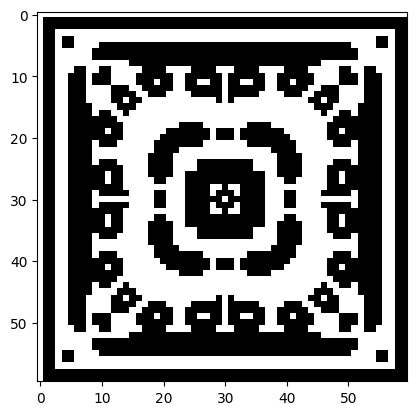

CPU times: user 5.17 s, sys: 152 ms, total: 5.32 s
Wall time: 5.07 s


In [4]:
%%time
X_train, Y_train, config = generate_totalistic_data(config, random_rule=126, random_init=False, stride=1)
print("\nLast state of the CA looks like this:")
cpl.plot2d(Y_train)

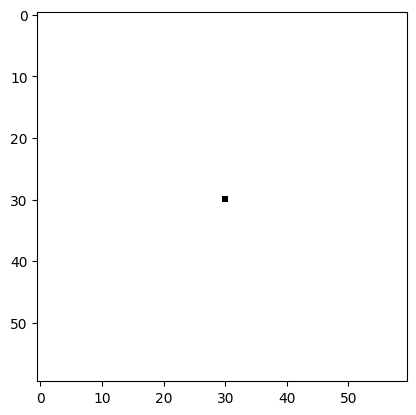

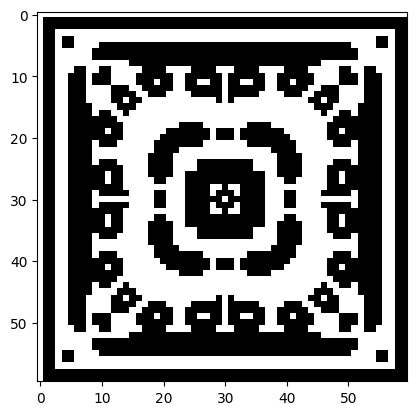

(29, 60, 60) (29, 60, 60) (1, 60, 60) (1, 60, 60) {'train_size': 30, 'wspan': 60, 'hspan': 60, 'num_classes': 2, 'layer_dims': [10, 10, 10, 10], 'learning_rate': 0.01, 'entropy': 1.528444094513062, 'avg_mutual_information': 1.0641744489652214}


In [15]:
## Create data with single seed as X and target img as Y
n_image = 1

seed = X_train[n_image-1:n_image, ...]
target_img = Y_train[-1:]

cpl.plot2d(seed)
cpl.plot2d(target_img)

# Print some information
print(X_train.shape, Y_train.shape, seed.shape, target_img.shape, config)

In [49]:
## Batch the seed and target imgs
BATCH_SIZE = 8
CHANNEL_N = 16

batched_seed = repeat(seed, 'b h w -> (n b) h w c', n=BATCH_SIZE, c=CHANNEL_N)
batched_target_img = repeat(target_img, 'b h w -> (n b) h w c', n=BATCH_SIZE, c=CHANNEL_N)
print(batched_seed.shape, batched_target_img.shape)

# Make 4th channel dimension be all ones
batched_seed[..., 3:] = np.ones_like(batched_seed[..., 3:])
batched_target_img[..., 3:] = np.ones_like(batched_target_img[..., 3:])

(8, 60, 60, 16) (8, 60, 60, 16)


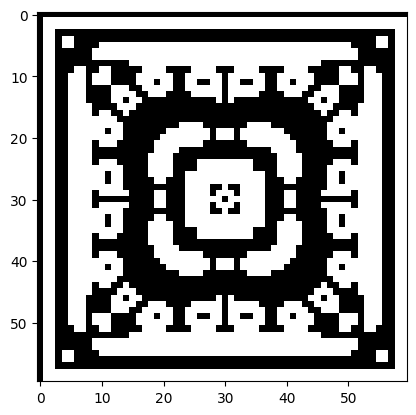

In [52]:
plt.imshow(batched_target_img[0, ..., :4])
plt.show()

(60, 60, 1)


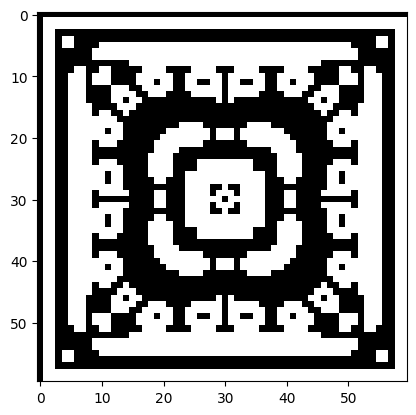

In [42]:
fst = batched_target_img[0, ..., 0:1]
snd = batched_target_img[0, ..., 1:2]
thrd = batched_target_img[0, ..., 2:3]
frth = batched_target_img[0, ..., 3:4]

print(fst.shape)
plt.imshow(frth, cmap='gray')

In [5]:
trainer = Trainer(network_fn, config, X_train, Y_train, n_iter=1, 
                  tags=["four-layer_dim", "one-n_iter", "seed_init", "zero_init_params", "2-classes"])

# trainer = Trainer(network_fn, config, batched_seed, batched_target_img, n_iter=config['train_size'], 
#                   tags=["four-layer_dim", "train_size-n_iter", "seed_init", "zero_init_params", "2-classes",
#                         "single_target",
#                        ]
#                  )

In [ ]:
state, loss, batch = trainer.train(epochs=701)

Initializing model


In [ ]:
losses, logits, preds = trainer.evaluate(state, batch, return_logits=True)
logits.shape, preds.shape, losses.shape

Showing output for sample index 8


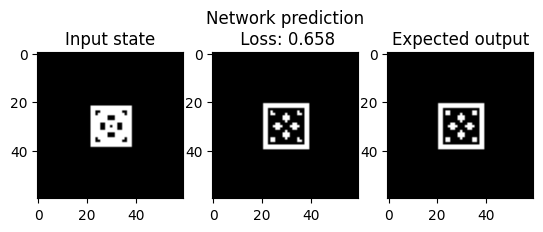

In [12]:
def sample_output(i=None):
    if i is None:
        i = np.random.randint(len(batch.input_states)-1)
    
    fig, (ax0, ax1, ax2) = plt.subplots(1, 3)
    ax0.imshow(batch.input_states[i], cmap='gray')
    ax1.imshow(preds[i], cmap='gray')
    ax2.imshow(batch.output_states[i], cmap='gray')

    print(f"Showing output for sample index {i}")
    ax0.set_title("Input state")
    ax1.set_title(f"Network prediction\n Loss: {losses[i]:.3f}")
    ax2.set_title("Expected output")

    # print(np.allclose(preds[i], batch.output_states[i], 1))
    
    fig.show()

sample_output()

In [ ]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 4))

ax1.hist(logits[..., 0])
ax2.hist(logits[..., 1])

fig.show()

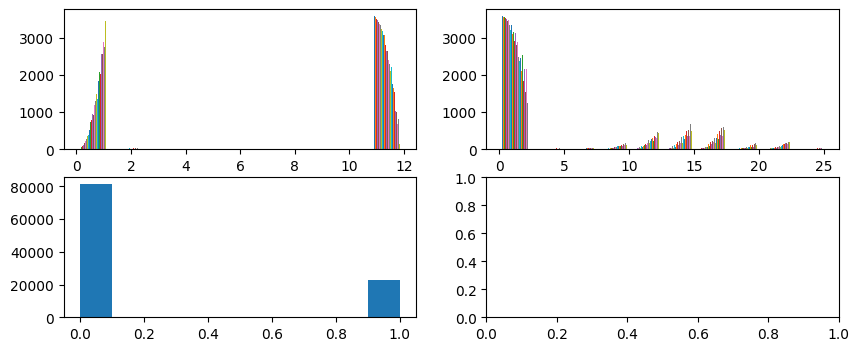

In [78]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))

ax1.hist(logits[..., 0])
ax2.hist(logits[..., 1])

ax3.hist(preds.flatten())

fig.show()

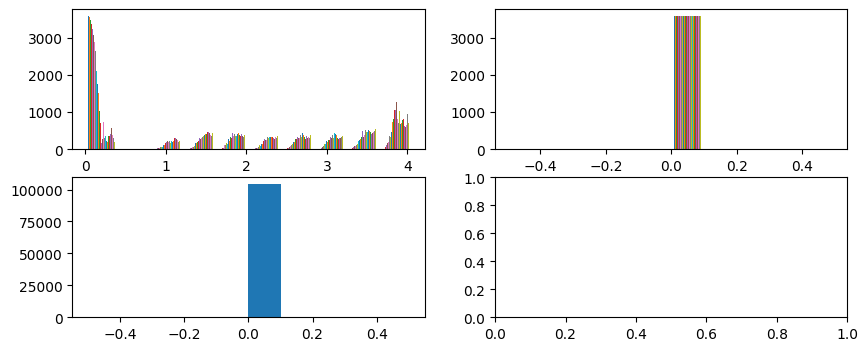

In [70]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 4))

ax1.hist(logits_bad[..., 0])
ax2.hist(logits_bad[..., 1])

ax3.hist(preds_bad.flatten())

fig.show()

In [72]:
logits_bad, preds_bad, losses_bad = logits.copy(), preds.copy(), losses.copy()

In [18]:
len(batch.input_states)

8

In [61]:
state.params.keys()

dict_keys(['ca_module/linear', 'ca_module/linear_1', 'ca_module/linear_2', 'ca_module/linear_3', 'ca_module/~/conv2_d', 'ca_module/~/linear'])

In [62]:
state.params['ca_module/linear_3']

{'b': Array([-0.18507124,  0.12888785, -0.55296755, -0.59000057,  0.43481705,
         0.42544165, -0.95925707,  0.6403715 ,  0.88835746,  0.02146218],      dtype=float32),
 'w': Array([[-0.46011412, -0.49597123,  0.23403665,  0.75543416, -0.70649654,
          0.1633972 ,  0.0887604 ,  0.46050438, -0.88369155,  0.8519378 ],
        [ 0.740303  ,  0.25721818,  0.16617723, -0.4229739 ,  0.07615218,
          0.03060856, -0.17897984,  0.16033585, -0.23333426, -0.7510644 ],
        [-0.8221125 , -0.4303284 , -0.5402759 , -0.5012186 , -0.5365846 ,
          0.5505804 , -0.23899461,  0.59414756,  0.41625816, -0.5035645 ],
        [-0.6828878 ,  0.46190402, -0.4170725 ,  0.38691446, -0.08315893,
          0.05753154,  0.134914  ,  0.341183  , -0.264602  , -0.6294272 ],
        [ 0.01463615,  0.46334365,  0.6845521 , -1.4652092 , -0.9418234 ,
         -0.47022212,  0.07483642, -0.08657282,  1.3146877 ,  0.4858109 ],
        [-0.20411657, -0.44177487, -0.2180563 ,  0.24908973, -0.30077153,
   

In [141]:
for key in state.params.keys():
    print(state.params[key])
    # plt.hist(state.params[key])

{'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'w': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)}
{'b': Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32), 'w': Array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],


In [80]:
testl = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
print(testl)

testX = testl[:-1]
testY = testl[1:]

# This prints the X and Y sets, one time step apart
print(testX, testY)

# Now try them two time steps apart:
print("\nTwo steps apart:")
testl2 = testl[::2]  # copy the list, skipping over every other element
print(testl2)

testX2 = testl2[:-1]
testY2 = testl2[1:]

print(testX2)
print(testY2)

testX3 = testl[::2][:-1]
testY3 = testl[::2][1:]

print()
print(testX3, testY3)

## For general n steps apart, just replace the 2 in the slice above with `n`

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14] [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Two steps apart:
[1, 3, 5, 7, 9, 11, 13, 15]
[1, 3, 5, 7, 9, 11, 13]
[3, 5, 7, 9, 11, 13, 15]

[1, 3, 5, 7, 9, 11, 13] [3, 5, 7, 9, 11, 13, 15]
